In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from scipy import linalg
import circle_fit as cf

## Question 1

In [6]:
N = 100
half_n = N//2
r = 10
s = r/16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x, y = (r+n)*np.cos(t), (r+n)*np.sin(t)
X_circle = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

In [367]:
def RANSAC_Circle(data_points):
    thres = np.std(data_points)/16  # threshold for RANSAC
    num_iterations = np.log(1 - 0.95)/np.log(1 - (1 - 0.5)**3)  
    iterations_done, max_inlier_count, selected_model = 0, 0, None

    while iterations_done < num_iterations:
        iterations_done += 1
        np.random.shuffle(data_points)  # randomly selecting 3 data points
        sample_data = data_points[:3]
        xc,yc,radius,_ = cf.least_squares_circle((sample_data)) # estimating a circle with selected data points
        center = (xc, yc)
        error = np.abs(radius - np.sqrt(np.sum((center - data_points[3:])**2, axis=1))) # computing error of remaining data points
        inliers = error <= thres # camparing the error with threshold
        inlier_count = np.count_nonzero(inliers) # number of inliers
        if inlier_count > max_inlier_count: # selecting the best model
            max_inlier_count = inlier_count
            inlier_points = []
            for index, inlier in enumerate(inliers): # filtering the inlier points
                if inlier == True:
                    inlier_points.append(data_points[3:][index])
            inlier_points = np.array(inlier_points)
            selected_model = (center, radius, data_points[:3], inlier_points)

    # refitting with all inliers
    xc,yc,radius,_ = cf.least_squares_circle(np.concatenate((selected_model[2], selected_model[3]), axis=0))
    best_model = ((xc, yc), radius, selected_model[2], selected_model[3])
    return best_model 

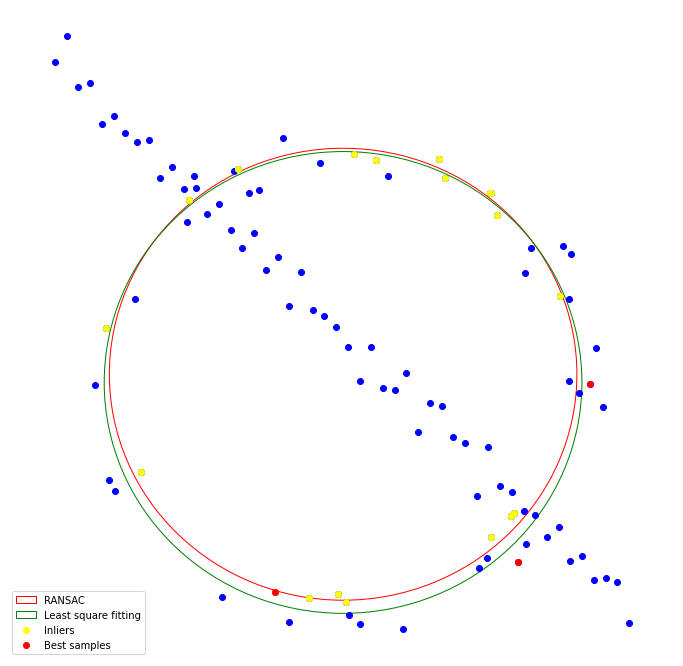

In [368]:
best_model = RANSAC_Circle(X_circle)
xc,yc,r,_ = cf.least_squares_circle((X_circle))

figure, ax = plt.subplots(figsize=(12, 12))
RASNSAC_circle = plt.Circle(best_model[0], best_model[1], fill=False, color='red', label='RANSAC')        
ax.add_artist(RASNSAC_circle)
circle = plt.Circle((xc, yc), r, fill=False, color='green', label='Least square fitting')    
ax.add_artist(circle)
ax.scatter(X_circle[:, 0], X_circle[:, 1], c='blue')
ax.scatter(X_line[:, 0], X_line[:, 1], c='blue')
ax.scatter(best_model[3][:, 0], best_model[3][:, 1], c='yellow', label='Inliers')
ax.scatter(best_model[2][:, 0], best_model[2][:, 1], c='red', label='Best samples')
plt.legend(loc=3)
plt.xlim(-14, 14)
plt.axis('off')
plt.savefig(r"Report\Images\1.png")
plt.show()

## Question 2

In [108]:
def mark_points(img, x, y):
    for i in range(y-5, y+5):
        for j in range(x-5, x+5):
            img[i][j] = [0,0,255]
    return

In [112]:
def super_impose(img2, file_name):
    img2_copy = np.copy(img2)
    img1 = cv.imread(r"Images\Flag_of_the_United_Kingdom.png", cv.IMREAD_COLOR)
    points1 = [(0, 0), (382, 0), (0, 191), (382, 191)]
    points2 = []

    def blend_n_show():
        H = cv.getPerspectiveTransform(np.float32(points1), np.float32(points2))
        img_p = cv.warpPerspective(img1, H, (img2.shape[1], img2.shape[0]))
        img_blended = cv.addWeighted(img2_copy, 1, img_p, 1, 0)
        cv.imshow('Architectural Image', img_blended)

        img2_ = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
        img_blended = cv.cvtColor(img_blended, cv.COLOR_BGR2RGB)
        fig, ax = plt.subplots(1, 2, figsize=(12, 12))
        ax[0].imshow(img2_)
        ax[0].axis('off')
        #ax[0].set_title("Selected Points")
        ax[1].imshow(img_blended)
        ax[1].axis('off')
        #ax[1].set_title("Super Imposed Image")
        plt.savefig("Report/Images/"+file_name)
        plt.show()
        return 

    def CallBackFunc(event, x, y, flags, userdata):
        if event == cv.EVENT_LBUTTONDOWN:
            if len(points2) < 4:
                mark_points(img2, x, y)
                cv.imshow("Architectural Image", img2)
                points2.append([x,y])
                if len(points2) == 4:
                    cv.destroyAllWindows()
                    blend_n_show()
        return 

    cv.namedWindow('Architectural Image')
    cv.setMouseCallback('Architectural Image', CallBackFunc)
    cv.imshow("Architectural Image", img2)
    cv.waitKey(0)
    return

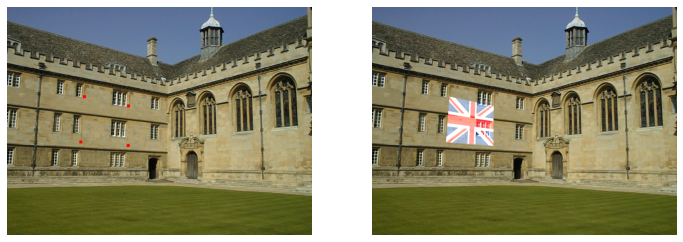

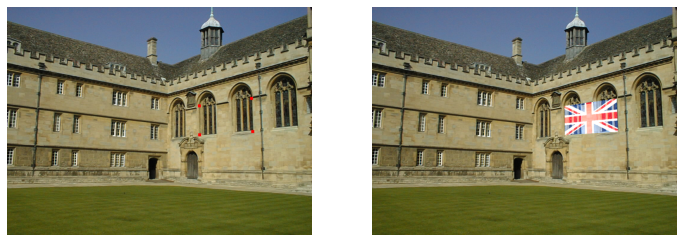

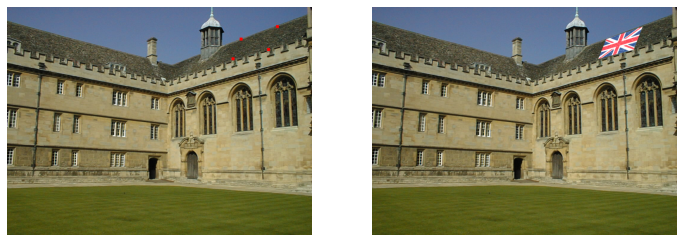

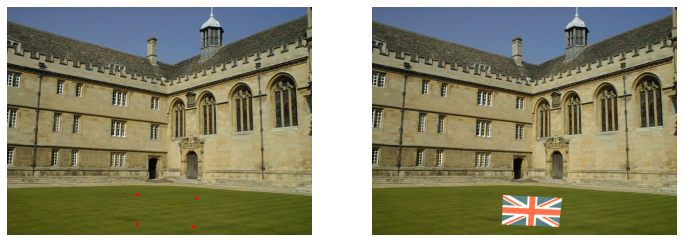

In [113]:
img = cv.imread(r"Images\002.jpg", cv.IMREAD_COLOR)
super_impose(np.copy(img), '21.png')
super_impose(np.copy(img), '22.png')
super_impose(np.copy(img), '23.png')
super_impose(np.copy(img), '24.png')

## Question 3

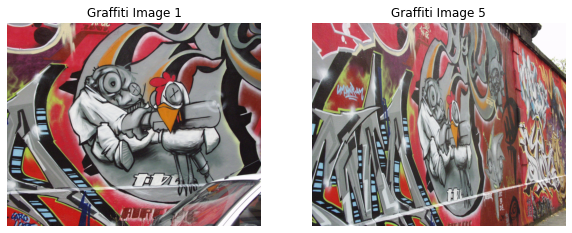

In [38]:
img1, img2 = cv.imread(r"graf\img1.ppm"), cv.imread(r"graf\img5.ppm")
img1, img2 = cv.cvtColor(img1, cv.COLOR_BGR2RGB), cv.cvtColor(img2, cv.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(img1)
ax[0].axis('off')
ax[0].set_title('Graffiti Image 1')
ax[1].imshow(img2)
ax[1].axis('off')
ax[1].set_title('Graffiti Image 5')
plt.show()

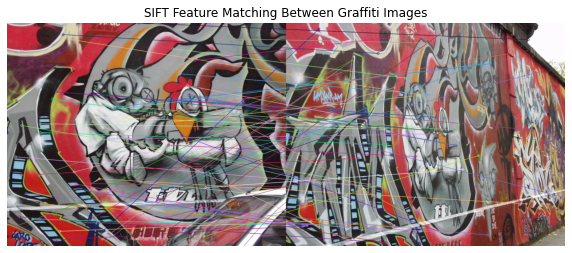

In [39]:
sift = cv.xfeatures2d.SIFT_create()

kp1, desc1 = sift.detectAndCompute(img1, None)
kp2, desc2 = sift.detectAndCompute(img2, None)

bf = cv.BFMatcher()
matches = bf.knnMatch(desc1, desc2, k=2)
good, pts1, pts2 = [], [], []

for m, n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

good, pts1, pts2 = np.array(good), np.array(pts1), np.array(pts2)
matched_img = cv.drawMatchesKnn(img1, kp1, img2, kp2, good[:100], None, flags=2)

fig, ax = plt.subplots(figsize = (10, 12))
ax.set_title('SIFT Feature Matching Between Graffiti Images')
ax.imshow(matched_img)
ax.axis('off')
plt.show()

In [40]:
def homography(pts1, pts2):
    mean1, mean2 = np.mean(pts1, axis=0), np.mean(pts2, axis=0)
    s1, s2 = len(pts1)*np.sqrt(2)/np.sum(np.sqrt(np.sum((pts1-mean1)**2, axis=1))), len(pts1)*np.sqrt(2)/np.sum(np.sqrt(np.sum((pts2-mean2)**2, axis=1)))
    tx1, ty1, tx2, ty2 = -s1*mean1[0], -s1*mean1[1], -s2*mean2[0], -s2*mean2[1]
    T1, T2 = np.array(((s1, 0, tx1), (0, s1, ty1), (0, 0, 1))), np.array(((s2, 0, tx2), (0, s2, ty2), (0, 0, 1)))
    A = []

    for i in range(len(pts1)):
        X11, X21 = T1 @ np.concatenate((pts1[i], [1])).reshape(3, 1), T2 @ np.concatenate((pts2[i], [1])).reshape(3, 1)
        A.append((-X11[0][0], -X11[1][0], -1, 0, 0, 0, X21[0][0]*X11[0][0], X21[0][0]*X11[1][0], X21[0][0]))
        A.append((0, 0, 0, -X11[0][0], -X11[1][0], -1, X21[1][0]*X11[0][0], X21[1][0]*X11[1][0], X21[1][0]))
    
    A = np.array(A)
    U, S, V = np.linalg.svd(A)
    h = np.reshape(V[-1], (3, 3))
    H = linalg.inv(T2) @ h @ T1
    H = (1 / H.item(8)) * H
    return H
        

In [41]:
def dist(P1, P2, H):
    p1 = np.array([P1[0], P1[1], 1])
    p2 = np.array([P2[0], P2[1], 1])

    p2_estimate = np.dot(H, np.transpose(p1))
    p2_estimate = (1 / p2_estimate[2]) * p2_estimate
    return np.linalg.norm(np.transpose(p2) - p2_estimate)

In [42]:
def RANSAC_homography(points1, points2):
    inlier_count, selected_inliers = 0, None
    points = np.hstack((points1, points2))
    num_iterations = int(np.log(1 - 0.95)/np.log(1 - (1 - 0.5)**4))
    
    for _ in range(num_iterations):
        np.random.shuffle(points)
        pts1, pts1_rem, pts2, pts2_rem = points[:4, :2],  points[4:, :2], points[:4, 2:], points[4:, 2:]
        H = homography(pts1, pts2)
        inliers = [(pts1_rem[i], pts2_rem[i]) for i in range(len(pts1_rem)) if dist(pts1_rem[i], pts2_rem[i], H) < 100]
        inliers = np.array(inliers)
        if len(inliers) > inlier_count:
            inlier_count = len(inliers)
            selected_inliers = inliers


    H = homography(selected_inliers[:, 0, :], selected_inliers[:, 1, :])
    h, _ = cv.findHomography(selected_inliers[:, 0], selected_inliers[:, 1], cv.RANSAC, 5.0)
    print(H)
    print(h)
    return H

H = RANSAC_homography(pts1, pts2) 

[[-8.74937101e-01 -1.79773284e-01  4.73932725e+02]
 [-5.88520827e-01 -1.05952161e-01  3.14025897e+02]
 [-1.83762455e-03 -3.81928140e-04  1.00000000e+00]]
[[-6.52225484e-01 -4.75052650e-01  4.66303574e+02]
 [-4.58579696e-01 -3.19336191e-01  3.20450178e+02]
 [-1.35924510e-03 -1.05486654e-03  1.00000000e+00]]


In [43]:
matrix, mask = cv.findHomography(pts1, pts2, cv.RANSAC, 5.0)
h = homography(pts1[:4], pts2[:4])

print(matrix)
#print(h)

[[-3.80531539e+00  2.87979469e+00 -1.25734861e+03]
 [-8.10858817e+00 -5.07626641e+00  3.37100113e+03]
 [-1.18139021e-02 -1.29702250e-03  1.00000000e+00]]
